#**Web Phishing Detection Using Deep Learning**

Advanced phishing detection project employing deep learning techniques on the 'look-before-you-leap' dataset, aiming at accurate identification of phishing threats through comprehensive raw URL and HTML content analysis.

**ALL CODES BY RAMADHIRRA. DO NOT USE OR COPY WITHOUT PERMISSION.**



---



# Install Dependencies

In [ ]:
!pip install nltk
!pip install scikit-learn
!pip install tensorflow
!pip install keras-tuner
!pip install prettytable

# Import Libraries

In [ ]:
# Standard library imports
import os
import sys
from collections import Counter
from tempfile import NamedTemporaryFile
from urllib.parse import urlparse, unquote
from urllib.request import urlopen
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

# Third-party imports for data manipulation and analysis
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

# Third-party imports for natural language processing
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import TextVectorization

# Third-party imports for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import keras_tuner
from kerastuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.metrics import Precision, Recall

# Third-party imports for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Google Colab specific import
from google.colab import drive

# Import Dataset

## Import Dataset From Kaggle

In [ ]:
# Define the size of data chunks to be read and processed at a time
CHUNK_SIZE = 40960

# Define a long URL string which is the data source mapping for the data to be downloaded
DATA_SOURCE_MAPPING = 'look-before-you-leap:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2446358%2F4141865%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240209%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240209T045558Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D26c8b451f9c02b8c69f4d6ac034539d94d44dac9c618815dcc0755f1012dc51030be0fc8082e269a9d1baef00651cd97c702b5b5337a093328996b7eb22e2416fedc48d0bce0df18282e182aa7aa8acaf36ceee74f13752efbcd43e9d5ef65a8f6418df5b71d0ade4e1327f9b1d142cd8980de3aaecf79cd1ab5364b6dfc51487bb42af97efa2090ec6dd52f78d6b0a3297ce68ec2c8168ac8cc989b58c0c7dccd61cfeb45876ab4996957c6f151d8cebda269c2969a47436e9fa0f23966b8b668fad8c9e29d43c89fe2d0dc1d9c5d8158e1bf41087c02cab0ff4ea1b1d16472b1cd14ce1e96d37bbf6faa4394e7ffa9c094162a4a4c77de0e7107d66c2c3d66'

# Define the input and working paths for the Kaggle environment
KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

# Unmount the '/kaggle/input' directory if it's already mounted
!umount /kaggle/input/ 2> /dev/null

# Delete the '/kaggle/input' directory and its contents if it already exists
shutil.rmtree('/kaggle/input', ignore_errors=True)

# Create the '/kaggle/input' and '/kaggle/working' directories with read-write-execute permissions for all users
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Create symbolic links to the '/kaggle/input' and '/kaggle/working' directories
try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

# Loop over each data source mapping in the DATA_SOURCE_MAPPING string
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
  # Extract the directory and download URL from the data source mapping
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    # Try to download and extract the data
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

# Print a completion message
print('Data source import complete.')

[==================================================] 218396561 bytes downloaded
Downloaded and uncompressed: look-before-you-leap
Data source import complete.


In [ ]:
# Loop over each directory path, directory names, and filenames in the '/kaggle/input' directory and its subdirectories
for dirname, _, filenames in os.walk('/kaggle/input'):
    # Loop over each file in the current directory
    for filename in filenames:
        # Print the complete path to the current file
        print(os.path.join(dirname, filename))

/kaggle/input/look-before-you-leap/html.xlsx
/kaggle/input/look-before-you-leap/URL.xlsx


#Mount Google Drive

In [ ]:
#Mount Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Load Dataset

In [ ]:
# Load the URL dataset
url_df = pd.read_excel('/kaggle/input/look-before-you-leap/URL.xlsx')

# Load the HTML dataset
html_df = pd.read_excel('/kaggle/input/look-before-you-leap/html.xlsx')

# Display the first few rows of each dataset to confirm successful loading
print("URL Dataset:")
print(url_df.head())
print("\nHTML Dataset:")
print(html_df.head())

URL Dataset:
  Category                                               Data
0     spam  logtelstra2021.ddnsking.com/0dfa1b53b835500696...
1     spam  dvsber.ru/modules/mod_ariimageslidersa/KRENK3N...
2     spam  kimsinc564.000webhostapp.com/notification.php?...
3     spam                                     benjim.com/all
4     spam                    www.m.micesrunescape.com-we.ru/

HTML Dataset:
  Category                                               Data
0     spam  <!DOCTYPE html>', '', '<html>', '<head>', '<me...
1     spam  <!DOCTYPE html><html dir="ltr" lang="en"><head...
2     spam  <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
3     spam  <meta content="1; URL=\'https://segurancaitauo...
4     spam  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//...


# Exploratory Data Analysis

## Overview of Data

In [ ]:
# Overview of Data
print("URL Dataset Shape:", url_df.shape)
print("HTML Dataset Shape:", html_df.shape)

URL Dataset Shape: (45373, 4)
HTML Dataset Shape: (45373, 4)


## Examine The Content

In [ ]:
# Content Examination
print("\nSample URLs:")
print(url_df['Data'].sample(5))
print("\nSample HTML Contents:")
print(html_df['Data'].sample(5))


Sample URLs:
25715                       www.isoc.org/internet/history/
18810                                       www.aeon-jp.cc
40421                         miolkoijhjhjhb.gq/CC_POSTALE
18744    www.theatlantic.com/unbound/digitalreader/dr20...
28869                 dimacs.rutgers.edu/Workshops/Faster/
Name: Data, dtype: object

Sample HTML Contents:
34050    <!DOCTYPE html><!--[if IE 8]><html class="ie8 ...
28401    <!DOCTYPE html><html class="no-js" lang="ja" p...
30395    <!DOCTYPE html><!--[if IE 8]><html class="no-j...
16411    <!DOCTYPE html>', '<html itemscope="" itemtype...
17942    <!DOCTYPE html>', '', '<html dir="rtl" prefix=...
Name: Data, dtype: object


## Print Data Types

In [ ]:
# Data Types
print("\nURL Dataset Data Types:")
print(url_df.dtypes)
print("\nHTML Dataset Data Types:")
print(html_df.dtypes)


URL Dataset Data Types:
Category            object
Data                object
Cleaned_Data        object
Category_Encoded     int64
dtype: object

HTML Dataset Data Types:
Category            object
Data                object
Cleaned_Data        object
Category_Encoded     int64
dtype: object


## Print Missing Values

In [ ]:
# Missing Values
print("\nMissing Values in URL Dataset:")
print(url_df.isnull().sum())
print("\nMissing Values in HTML Dataset:")
print(html_df.isnull().sum())


Missing Values in URL Dataset:
Category            0
Data                0
Cleaned_Data        0
Category_Encoded    0
dtype: int64

Missing Values in HTML Dataset:
Category            0
Data                0
Cleaned_Data        0
Category_Encoded    0
dtype: int64


## Print Value Counts

In [ ]:
# Value Counts
print("\nCategory Distribution in URL Dataset:")
print(url_df['Category'].value_counts())
print("\nCategory Distribution in HTML Dataset:")
print(html_df['Category'].value_counts())


Category Distribution in URL Dataset:
ham     22687
spam    22686
Name: Category, dtype: int64

Category Distribution in HTML Dataset:
ham     22687
spam    22686
Name: Category, dtype: int64


## Print Unique Values

In [ ]:
# Unique Values
print("\nUnique URLs:", url_df['Data'].nunique())
print("Unique HTML Contents:", html_df['Data'].nunique())


Unique URLs: 44078
Unique HTML Contents: 32707


## Distribution of Categories in URL Dataset

<ipython-input-91-5c41c2303e6d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Category', data=url_df, palette=color_palette)


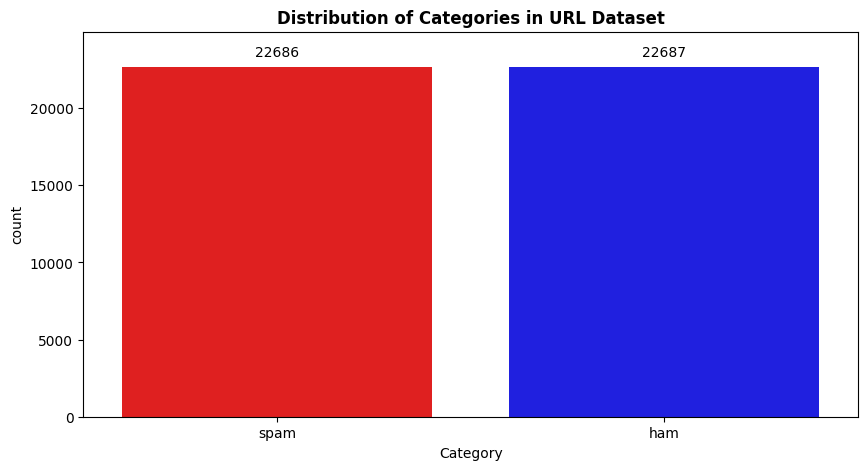

In [ ]:
# Visualize Distribution of Categories in URL Dataset
plt.figure(figsize=(10, 5))

# Create a customized color palette
color_palette = ['red', 'blue']

# Plot a countplot with the specified color palette
ax = sns.countplot(x='Category', data=url_df, palette=color_palette)

# Add a title to the plot
plt.title('Distribution of Categories in URL Dataset', fontweight='bold')

# Add exact values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# Extend y-limit to make space for the text
ax.set_ylim(0, max([p.get_height() for p in ax.patches])*1.1)

# Show the plot
plt.show()

## Distribution of Categories in HTML Dataset

<ipython-input-92-c4c279d52d65>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Category', data=html_df, palette=color_palette)


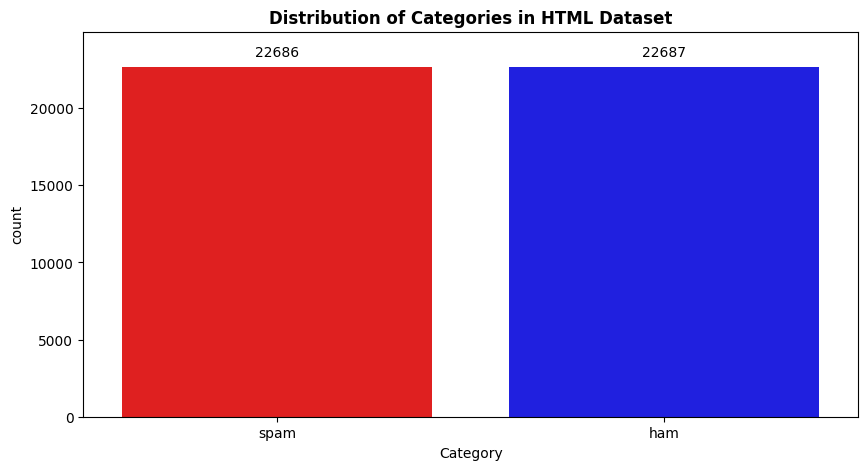

In [ ]:
# Visualize Distribution of Categories in HTML Dataset
plt.figure(figsize=(10, 5))

# Create a customized color palette
color_palette = ['red', 'blue']

# Plot a countplot with the specified color palette
ax = sns.countplot(x='Category', data=html_df, palette=color_palette)

# Add a title to the plot
plt.title('Distribution of Categories in HTML Dataset', fontweight='bold')

# Add exact values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# Extend y-limit to make space for the text
ax.set_ylim(0, max([p.get_height() for p in ax.patches])*1.1)

# Show the plot
plt.show()

## Check Distribution Percentages

In [ ]:
# Distribution Percentages
url_category_percentage = url_df['Category'].value_counts(normalize=True) * 100
html_category_percentage = html_df['Category'].value_counts(normalize=True) * 100
print("\nURL Category Distribution Percentage:")
print(url_category_percentage)
print("\nHTML Category Distribution Percentage:")
print(html_category_percentage)


URL Category Distribution Percentage:
ham     50.001102
spam    49.998898
Name: Category, dtype: float64

HTML Category Distribution Percentage:
ham     50.001102
spam    49.998898
Name: Category, dtype: float64


## Visualize URL Category Distribution Percentage

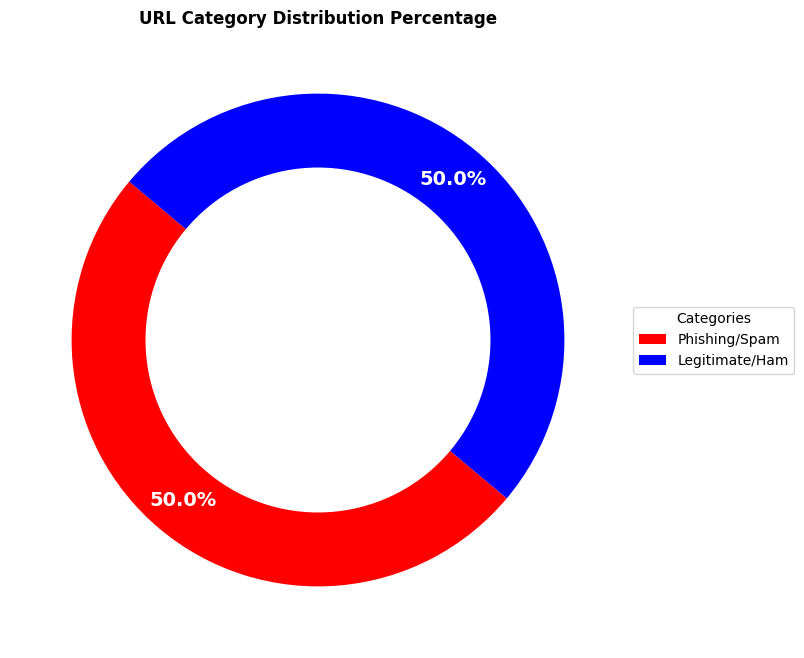

In [ ]:
# Visualize Distributions
fig, ax = plt.subplots(figsize=(8, 8))

# Create a customized color palette
colors = ['red', 'blue'] # Red for phishing, blue for legitimate

# Plot a pie chart with the specified color palette
wedges, texts, autotexts = ax.pie(url_category_percentage, autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85)

# Draw a white circle at the center (for aesthetics)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Change the font size of the percentage labels
plt.setp(autotexts, size=14, weight="bold", color="white")

# Add a title to the plot
plt.title('URL Category Distribution Percentage', fontweight='bold')

# Add a legend
ax.legend(wedges, ['Phishing/Spam', 'Legitimate/Ham'], title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Hide the y-label as it's unnecessary here
plt.ylabel('')

# Show the plot
plt.show()


## Visualize HTML Category Distribution Percentage

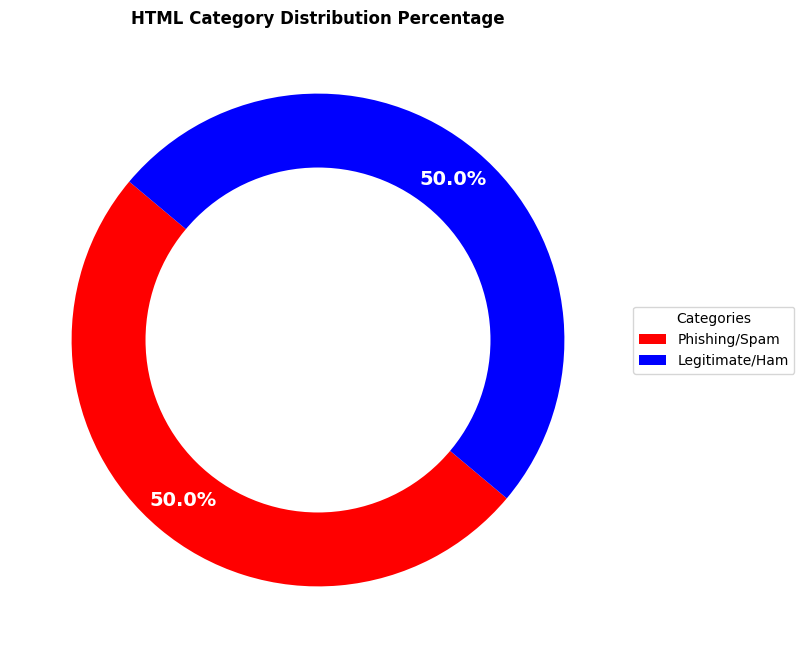

In [ ]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 8))

# Create a customized color palette
colors = ['red', 'blue'] # Red for phishing, blue for legitimate

# Plot a pie chart with the specified color palette
wedges, texts, autotexts = ax.pie(html_category_percentage, autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85)

# Draw a white circle at the center (for aesthetics)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Change the font size of the percentage labels
plt.setp(autotexts, size=14, weight="bold", color="white")

# Add a title to the plot
plt.title('HTML Category Distribution Percentage', fontweight='bold')

# Add a legend
ax.legend(wedges, ['Phishing/Spam', 'Legitimate/Ham'], title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Hide the y-label as it's unnecessary here
plt.ylabel('')

# Show the plot
plt.show()

## URL Length Analysis

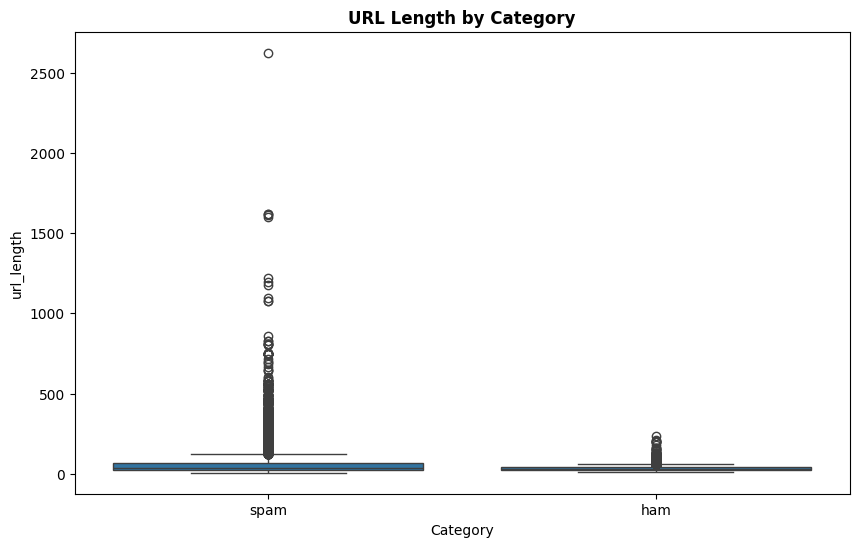

In [ ]:
# URL Length Analysis
url_df['url_length'] = url_df['Data'].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='url_length', data=url_df)
plt.title('URL Length by Category', fontweight="bold")
plt.show()

## HTML Length Analysis

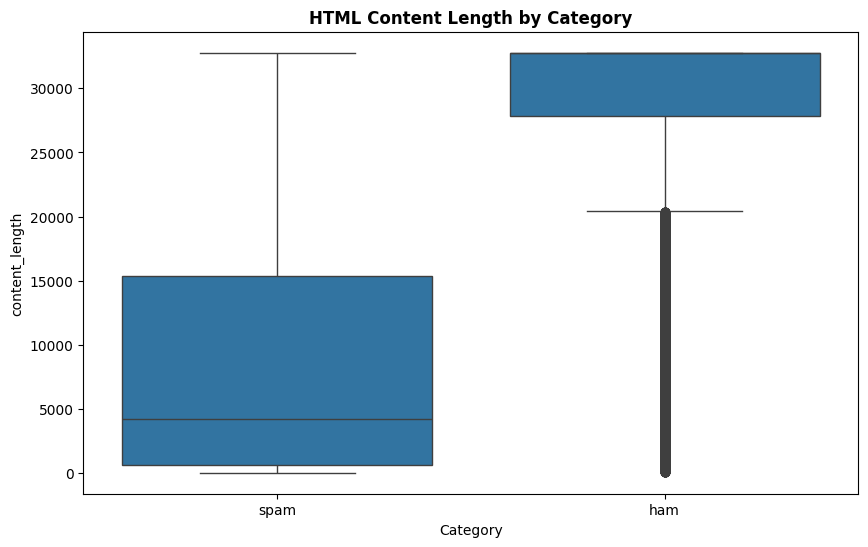

In [ ]:
# HTML Content Length Analysis
html_df['content_length'] = html_df['Data'].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='content_length', data=html_df)
plt.title('HTML Content Length by Category', fontweight="bold")
plt.show()

# Preprocessing

## Download NLTK Resources

In [ ]:
# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Load Stopwords

In [ ]:
# Load stopwords once to improve efficiency
STOPWORDS = set(stopwords.words('english'))

## Initialize Lemmatizer

In [ ]:
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

## Clean and Preprocess URL Data

In [ ]:
# Function to clean and preprocess URL data
def preprocess_url(url):
    url = url.lower()  # Convert to lowercase
    url = re.sub(r'https?://', '', url)  # Remove http or https
    url = re.sub(r'www\.', '', url)  # Remove www
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)  # Remove special characters
    url = re.sub(r'\s+', ' ', url).strip()  # Remove extra spaces
    tokens = word_tokenize(url)  # Tokenize
    tokens = [word for word in tokens if word not in STOPWORDS]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

## Clean and Preprocess HTML Data

In [ ]:
# Function to clean and preprocess HTML data
def preprocess_html(html):
    html = re.sub(r'<[^>]+>', ' ', html)  # Remove HTML tags
    html = html.lower()  # Convert to lowercase
    html = re.sub(r'https?://', '', html)  # Remove http or https
    html = re.sub(r'[^a-zA-Z0-9]', ' ', html)  # Remove special characters
    html = re.sub(r'\s+', ' ', html).strip()  # Remove extra spaces
    tokens = word_tokenize(html)  # Tokenize
    tokens = [word for word in tokens if word not in STOPWORDS]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

## Clean URL 'Data' Columns

In [ ]:
# Clean URL 'Data' Columns
url_df['Cleaned_Data'] = url_df['Data'].apply(preprocess_url)

## Clean HTML 'Data' Columns

In [ ]:
# Clean HTML 'Data' Columns
html_df['Cleaned_Data'] = html_df['Data'].apply(preprocess_html)

## Print Cleaned URL Data

In [ ]:
# URL Data After Cleaning
print("URL Data After Cleaning:")
display(url_df[['Data', 'Cleaned_Data']].head())

URL Data After Cleaning:


,Data,Cleaned_Data
0,logtelstra2021.ddnsking.com/0dfa1b53b835500696...,logtelstra2021 ddnsking com 0dfa1b53b835500696...
1,dvsber.ru/modules/mod_ariimageslidersa/KRENK3N...,dvsber ru module mod ariimageslidersa krenk3n4...
2,kimsinc564.000webhostapp.com/notification.php?...,kimsinc564 000webhostapp com notification php ...
3,benjim.com/all,benjim com
4,www.m.micesrunescape.com-we.ru/,micesrunescape com ru


## Print Cleaned HTML Data

In [ ]:
# HTML Data After Cleaning
print("\nHTML Data After Cleaning:")
display(html_df[['Data', 'Cleaned_Data']].head())


HTML Data After Cleaning:


,Data,Cleaned_Data
0,"<!DOCTYPE html>', '', '<html>', '<head>', '<me...",send money pay online set merchant account pay...
1,"<!DOCTYPE html><html dir=""ltr"" lang=""en""><head...",window wiz global data dpimgf false ep1ykd acc...
2,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",url error talktalk co uk main participantid nm...
3,"<meta content=""1; URL=\'https://segurancaitauo...",
4,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01//...",sign microsoft online service ie legacy displa...


## Define Maximum Length of Sequences

In [ ]:
# Define the maximum length of sequences
max_url_length = 180
max_html_length = 2000

## Define Maximum Number of Words

In [ ]:
# Define the maximum number of words/tokens
max_words = 10000

## URL Tokenization and Padding

In [ ]:
# URL Tokenization and Padding
url_tokenizer = Tokenizer(num_words=max_words, char_level=True)  # char_level=True for character-level tokenization
url_tokenizer.fit_on_texts(url_df['Cleaned_Data'])
url_sequences = url_tokenizer.texts_to_sequences(url_df['Cleaned_Data'])
url_padded = pad_sequences(url_sequences, maxlen=max_url_length, padding='post', truncating='post')

## HTML Tokenization and Padding

In [ ]:
# HTML Tokenization and Padding
html_tokenizer = Tokenizer(num_words=max_words)  # Word-level tokenization by default
html_tokenizer.fit_on_texts(html_df['Cleaned_Data'])
html_sequences = html_tokenizer.texts_to_sequences(html_df['Cleaned_Data'])
html_padded = pad_sequences(html_sequences, maxlen=max_html_length, padding='post', truncating='post')

## Encode 'Category' Column

In [ ]:
# Encode 'Category' column
label_encoder = LabelEncoder()
url_df['Category_Encoded'] = label_encoder.fit_transform(url_df['Category'])
html_df['Category_Encoded'] = label_encoder.transform(html_df['Category'])  # Ensure HTML uses the same encoding as URL

## Split Datasets Into Training and Testing Sets

In [ ]:
# Split datasets into training and testing sets
url_X_train, url_X_test, url_y_train, url_y_test = train_test_split(url_padded, url_df['Category_Encoded'], test_size=0.2, random_state=42)
html_X_train, html_X_test, html_y_train, html_y_test = train_test_split(html_padded, html_df['Category_Encoded'], test_size=0.2, random_state=42)

#Model Building

## Create Model Architecture

In [ ]:
def create_model():
    # Adjusted hyperparameters
    embedding_dim = 32  # Increased embedding dimension
    conv_filters = 128  # Increased number of filters in convolutional layers
    kernel_size = 10 # Increased kernel size
    dense_units_1 = 128
    dense_units_2 = 64
    learning_rate = 0.0005  # Adjusted learning rate

    # Model architecture
    url_input = layers.Input(shape=(max_url_length,), name='url_input')
    url_embedding = layers.Embedding(input_dim=min(max_words, len(url_tokenizer.word_index) + 1),
                                     output_dim=embedding_dim, input_length=max_url_length, name='url_embedding')(url_input)
    url_conv = layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(url_embedding)
    url_pool = layers.MaxPooling1D(pool_size=2)(url_conv)
    url_flat = layers.Flatten()(url_pool)

    html_input = layers.Input(shape=(max_html_length,), name='html_input')
    html_embedding = layers.Embedding(input_dim=min(max_words, len(html_tokenizer.word_index) + 1),
                                      output_dim=embedding_dim, input_length=max_html_length, name='html_embedding')(html_input)
    html_conv = layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(html_embedding)
    html_pool = layers.MaxPooling1D(pool_size=2)(html_conv)
    html_flat = layers.Flatten()(html_pool)

    concatenated = layers.Concatenate(name='concatenate_layer')([url_flat, html_flat])
    dense1 = layers.Dense(dense_units_1, activation='relu', name='dense1')(concatenated)
    dense2 = layers.Dense(dense_units_2, activation='relu', name='dense2')(dense1)
    output = layers.Dense(1, activation='sigmoid', name='output_layer')(dense2)

    # Model compilation with directly imported metrics
    model = models.Model(inputs=[url_input, html_input], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    return model

## Creating The Model

In [ ]:
# Create the model
model = create_model()

## Print Model Summary

In [ ]:
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 url_input (InputLayer)      [(None, 180)]                0         []                            
                                                                                                  
 html_input (InputLayer)     [(None, 2000)]               0         []                            
                                                                                                  
 url_embedding (Embedding)   (None, 180, 32)              1216      ['url_input[0][0]']           
                                                                                                  
 html_embedding (Embedding)  (None, 2000, 32)             320000    ['html_input[0][0]']          
                                                                                              

#Training

## Add Early Stopping

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Train The Model

In [ ]:
# Model Training
history = model.fit(
    [url_X_train, html_X_train],  # URL and HTML training data
    url_y_train,
    validation_data=([url_X_test, html_X_test], url_y_test),  # URL and HTML validation data
    epochs=25,  # Number of epochs to train for
    batch_size=8,  # Batch size for training
    callbacks=[early_stopping]  # Early stopping callback
)

Epoch 1/25
4538/4538 [==============================] - 254s 55ms/step - loss: 0.1360 - accuracy: 0.9493 - precision: 0.9510 - recall: 0.9476 - val_loss: 0.0791 - val_accuracy: 0.9741 - val_precision: 0.9811 - val_recall: 0.9665
Epoch 2/25
4538/4538 [==============================] - 90s 20ms/step - loss: 0.0416 - accuracy: 0.9858 - precision: 0.9863 - recall: 0.9853 - val_loss: 0.0697 - val_accuracy: 0.9794 - val_precision: 0.9804 - val_recall: 0.9781
Epoch 3/25
4538/4538 [==============================] - 73s 16ms/step - loss: 0.0188 - accuracy: 0.9936 - precision: 0.9935 - recall: 0.9937 - val_loss: 0.0939 - val_accuracy: 0.9769 - val_precision: 0.9727 - val_recall: 0.9809
Epoch 4/25
4538/4538 [==============================] - 69s 15ms/step - loss: 0.0119 - accuracy: 0.9959 - precision: 0.9957 - recall: 0.9960 - val_loss: 0.1126 - val_accuracy: 0.9758 - val_precision: 0.9840 - val_recall: 0.9670
Epoch 5/25
4538/4538 [==============================] - 68s 15ms/step - loss: 0.0102 - 

#Evaluation

## Evaluate The Model

In [ ]:
# Model Evaluation
y_pred_prob = model.predict([url_X_test, html_X_test])
y_pred = (y_pred_prob > 0.5).astype(int)

284/284 [==============================] - 2s 5ms/step


## Calculating Model Performance Based on Metrics

In [ ]:
# Calculating metrics
accuracy = accuracy_score(url_y_test, y_pred)
precision = precision_score(url_y_test, y_pred)
recall = recall_score(url_y_test, y_pred)
f1 = f1_score(url_y_test, y_pred)

## Print Evaluation Metrics

In [ ]:
# Printing evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9794
Precision: 0.9804
Recall: 0.9781
F1 Score: 0.9792


## Visualize The Result of Evaluation Metrics

<ipython-input-30-6b117a40e989>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metrics', y='Values', data=df, palette=cm)


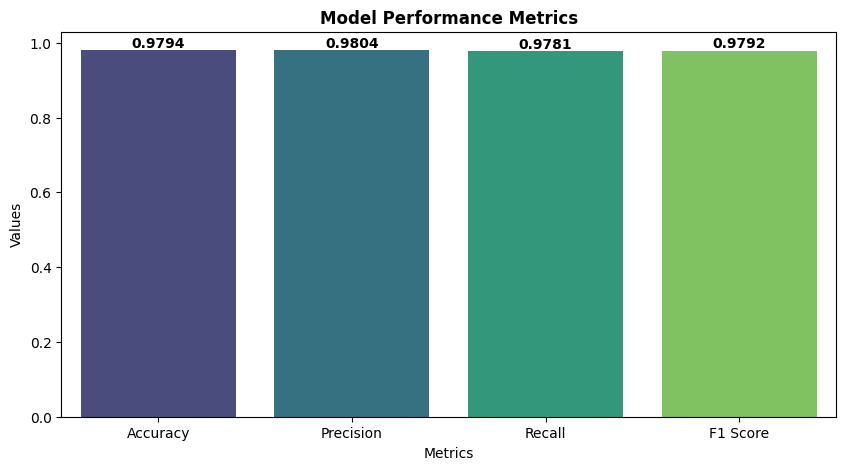

In [ ]:
# Prepare data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

# Create DataFrame
df = pd.DataFrame(list(zip(metrics, values)), columns=['Metrics', 'Values'])

# Set color palette
cm = sns.color_palette('viridis', len(values))

# Create bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x='Metrics', y='Values', data=df, palette=cm)

# Display values on bars
for i in range(len(values)):
    plt.text(i, values[i], round(values[i], 4), ha='center', va='bottom', fontweight='bold', color='black')

# Add title
plt.title("Model Performance Metrics", fontweight='bold')

# Show the plot
plt.show()

## Confusion Matrix

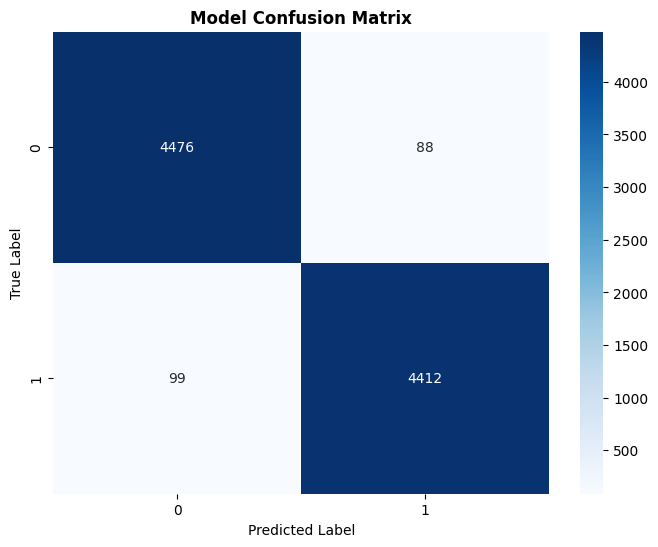

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(url_y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Model Confusion Matrix", fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Plotting Training and Validation Loss

In [ ]:
# Extracting values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Epochs range
epochs_range = range(1, len(training_loss) + 1)

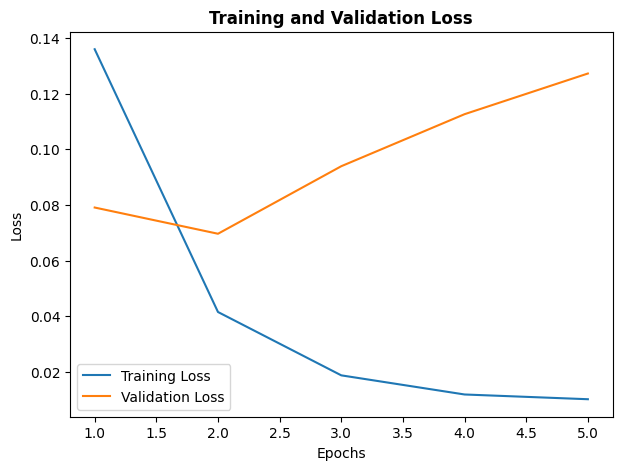

In [ ]:
# Plotting Training and Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')  # Save the figure as an image
plt.show()

## Plotting Training and Validation Accuracy

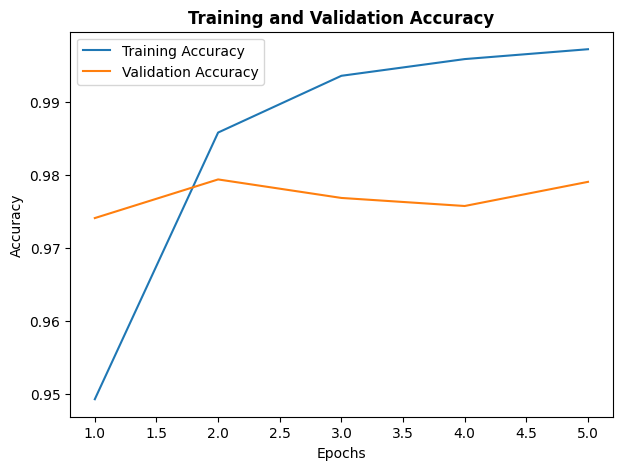

In [ ]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')  # Save the figure as an image
plt.show()

# Save The Model

In [ ]:
# Define file path
model.save('/content/drive/MyDrive/phishing_detection_model.keras')

# Test The Model

In [ ]:
# Defining new benchmark data
new_urls = [
    "http://www.horadiadacompras.com/simples-login/entrar&amp;hnuhgjb",
    "https://portalnews.com/account/",
    "http://facebook-prize.com/offer/",
    "https://thediasuniversity.edu/our-achievements/",
    "http://paypal-secure-account.blogspot.com/"
]

new_htmls = [
    "<html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>",
    "<!DOCTYPE html><html><head><title>News Update</title></head><body>Welcome to our news portal</body></html>",
    "<html><head><script>var a=1; stealCredentials();</script></head><body>Login to see content</body></html>",
    "<!DOCTYPE html><html lang=en><head><title>University of Thedias</title></head><body>Our Achievements</body></html>",
    "<html><head><title>Your Account Has Been Suspended</title></head><body>Please log in to verify your account</body></html>"
]

actual_categories = ["spam", "ham", "spam", "ham", "spam"]  # Assuming the categories for the new benchmark data

# Preprocessing the new benchmark data
cleaned_urls = [preprocess_url(url) for url in new_urls]
cleaned_htmls = [preprocess_html(html) for html in new_htmls]

# Tokenizing and padding
new_url_sequences = url_tokenizer.texts_to_sequences(cleaned_urls)
new_url_padded = pad_sequences(new_url_sequences, maxlen=max_url_length, padding='post', truncating='post')

new_html_sequences = html_tokenizer.texts_to_sequences(cleaned_htmls)
new_html_padded = pad_sequences(new_html_sequences, maxlen=max_html_length, padding='post', truncating='post')

# Making predictions with the model
new_predictions_prob = model.predict([new_url_padded, new_html_padded])
new_predictions = (new_predictions_prob > 0.5).astype(int)  # Using 0.5 as the threshold for binary classification

# Displaying actual categories, predicted probabilities, and predicted categories
for i, (url, html) in enumerate(zip(new_urls, new_htmls)):
    actual_category = "Spam" if actual_categories[i] == "spam" else "Legitimate"
    predicted_category = "Spam" if new_predictions[i][0] == 1 else "Legitimate"
    print(f"URL: {url}")
    print(f"HTML Content: {html[:100]}...")  # Displaying a snippet for brevity
    print(f"Actual Category: {actual_category}")
    print(f"Predicted Probability: {new_predictions_prob[i][0]:.4f}")
    print(f"Predicted Category: {predicted_category}\n")

1/1 [==============================] - 0s 35ms/step
URL: http://www.horadiadacompras.com/simples-login/entrar&amp;hnuhgjb
HTML Content: <html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>...
Actual Category: Spam
Predicted Probability: 0.9891
Predicted Category: Spam

URL: https://portalnews.com/account/
HTML Content: <!DOCTYPE html><html><head><title>News Update</title></head><body>Welcome to our news portal</body><...
Actual Category: Legitimate
Predicted Probability: 0.1116
Predicted Category: Legitimate

URL: http://facebook-prize.com/offer/
HTML Content: <html><head><script>var a=1; stealCredentials();</script></head><body>Login to see content</body></h...
Actual Category: Spam
Predicted Probability: 0.9775
Predicted Category: Spam

URL: https://thediasuniversity.edu/our-achievements/
HTML Content: <!DOCTYPE html><html lang=en><head><title>University of Thedias</title></head><body>Our Achievements...
Actual Category: Legitimate
Predi

In [ ]:
# Define new benchmark data
new_urls = [
"http://www.horadiadacompras.com/simples-login/entrar&hnuhgjb",
"https://portalnews.com/account/",
"http://facebook-prize.com/offer/",
"https://thediasuniversity.edu/our-achievements/",
"http://paypal-secure-account.blogspot.com/",
"http://secure-login-paypal.com/",
"http://amazon-prime-offers.com/",
"https://secure-bankofamerica.com/login/",
"http://netflix-secure-login.com/",
"https://wellsfargo-secure.com/",
"https://stanford.edu/research/",
"http://gmail-security.com/",
"http://www.airbnb-login.com/",
"https://harvard.edu/admissions/",
"https://linkedin-security.com/",
"http://ebay-security.com/",
"https://paypal-security.com/",
"https://bankofamerica-secure.com/",
"http://www.microsoft-security.com/",
"https://apple-secure.com/"
]

new_htmls = [
"<html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>",
"<!DOCTYPE html><html><head><title>News Update</title></head><body>Welcome to our news portal</body></html>",
"<html><head><script>var a=1; stealCredentials();</script></head><body>Login to see content</body></html>",
"<!DOCTYPE html><html lang=en><head><title>University of Thedias</title></head><body>Our Achievements</body></html>",
"<html><head><title>Your Account Has Been Suspended</title></head><body>Please log in to verify your account</body></html>",
"<html><head><title>Secure Login</title></head><body>Please enter your PayPal credentials</body></html>",
"<html><head><title>Amazon Prime Offers</title></head><body>Click here to claim your Amazon Prime offers</body></html>",
"<html><head><title>Secure Login</title></head><body>Enter your Bank of America login details</body></html>",
"<html><head><title>Netflix Login</title></head><body>Please enter your Netflix credentials</body></html>",
"<html><head><title>Secure Login</title></head><body>Enter your Wells Fargo login details</body></html>",
"<!DOCTYPE html><html lang=en><head><title>Stanford Research</title></head><body>Information about our research</body></html>",
"<html><head><title>Gmail Security</title></head><body>Please enter your Gmail credentials</body></html>",
"<html><head><title>Airbnb Login</title></head><body>Please enter your Airbnb credentials</body></html>",
"<!DOCTYPE html><html lang=en><head><title>Harvard Admissions</title></head><body>Information about admissions</body></html>",
"<html><head><title>LinkedIn Security</title></head><body>Please enter your LinkedIn credentials</body></html>",
"<html><head><title>eBay Security</title></head><body>Please enter your eBay credentials</body></html>",
"<html><head><title>PayPal Security</title></head><body>Please enter your PayPal credentials</body></html>",
"<html><head><title>Bank of America Security</title></head><body>Please enter your Bank of America credentials</body></html>",
"<html><head><title>Microsoft Security</title></head><body>Please enter your Microsoft credentials</body></html>",
"<html><head><title>Apple Security</title></head><body>Please enter your Apple credentials</body></html>"
]

actual_categories = ["spam", "ham", "spam", "ham", "spam", "spam", "spam", "spam", "spam", "spam", "ham", "spam", "spam", "ham", "spam", "spam", "spam", "spam", "spam", "spam"]

# Preprocess the new benchmark data
cleaned_urls = [preprocess_url(url) for url in new_urls]
cleaned_htmls = [preprocess_html(html) for html in new_htmls]

# Tokenize and pad
new_url_sequences = url_tokenizer.texts_to_sequences(cleaned_urls)
new_url_padded = pad_sequences(new_url_sequences, maxlen=max_url_length, padding='post', truncating='post')

new_html_sequences = html_tokenizer.texts_to_sequences(cleaned_htmls)
new_html_padded = pad_sequences(new_html_sequences, maxlen=max_html_length, padding='post', truncating='post')

# Make predictions with the model
new_predictions_prob = model.predict([new_url_padded, new_html_padded])
new_predictions = (new_predictions_prob > 0.5).astype(int)

# Define the table
table = PrettyTable()
table.field_names = ["URL", "HTML Snippet", "Actual", "Predicted Probability", "Predicted Category"]

# Populate the table
for i, (url, html) in enumerate(zip(new_urls, new_htmls)):
    html_snippet = html[:100] + "..."  # Displaying a snippet for brevity
    actual_category = "Spam" if actual_categories[i] == "spam" else "Legitimate"
    predicted_category = "Spam" if new_predictions[i][0] == 1 else "Legitimate"
    table.add_row([url, html_snippet, actual_category, f"{new_predictions_prob[i][0]:.4f}", predicted_category])

# Print the table
print(table)

1/1 [==============================] - 0s 34ms/step
+--------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+------------+-----------------------+--------------------+
|                             URL                              |                                               HTML Snippet                                              |   Actual   | Predicted Probability | Predicted Category |
+--------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+------------+-----------------------+--------------------+
| http://www.horadiadacompras.com/simples-login/entrar&hnuhgjb |  <html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>... |    Spam    |         0.9934        |        Spam        |
|               https://portalne

# Load The Saved Model and Try It

In [ ]:
# Load trained model
model = keras.models.load_model('/content/drive/MyDrive/phishing_detection_model.keras')

In [ ]:
# Define new benchmark data
new_urls = [
"http://www.horadiadacompras.com/simples-login/entrar&hnuhgjb",
"https://portalnews.com/account/",
"http://facebook-prize.com/offer/",
"https://thediasuniversity.edu/our-achievements/",
"http://paypal-secure-account.blogspot.com/",
"http://secure-login-paypal.com/",
"http://amazon-prime-offers.com/",
"https://secure-bankofamerica.com/login/",
"http://netflix-secure-login.com/",
"https://wellsfargo-secure.com/",
"https://stanford.edu/research/",
"http://gmail-security.com/",
"http://www.airbnb-login.com/",
"https://harvard.edu/admissions/",
"https://linkedin-security.com/",
"http://ebay-security.com/",
"https://paypal-security.com/",
"https://bankofamerica-secure.com/",
"http://www.microsoft-security.com/",
"https://apple-secure.com/"
]

new_htmls = [
"<html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>",
"<!DOCTYPE html><html><head><title>News Update</title></head><body>Welcome to our news portal</body></html>",
"<html><head><script>var a=1; stealCredentials();</script></head><body>Login to see content</body></html>",
"<!DOCTYPE html><html lang=en><head><title>University of Thedias</title></head><body>Our Achievements</body></html>",
"<html><head><title>Your Account Has Been Suspended</title></head><body>Please log in to verify your account</body></html>",
"<html><head><title>Secure Login</title></head><body>Please enter your PayPal credentials</body></html>",
"<html><head><title>Amazon Prime Offers</title></head><body>Click here to claim your Amazon Prime offers</body></html>",
"<html><head><title>Secure Login</title></head><body>Enter your Bank of America login details</body></html>",
"<html><head><title>Netflix Login</title></head><body>Please enter your Netflix credentials</body></html>",
"<html><head><title>Secure Login</title></head><body>Enter your Wells Fargo login details</body></html>",
"<!DOCTYPE html><html lang=en><head><title>Stanford Research</title></head><body>Information about our research</body></html>",
"<html><head><title>Gmail Security</title></head><body>Please enter your Gmail credentials</body></html>",
"<html><head><title>Airbnb Login</title></head><body>Please enter your Airbnb credentials</body></html>",
"<!DOCTYPE html><html lang=en><head><title>Harvard Admissions</title></head><body>Information about admissions</body></html>",
"<html><head><title>LinkedIn Security</title></head><body>Please enter your LinkedIn credentials</body></html>",
"<html><head><title>eBay Security</title></head><body>Please enter your eBay credentials</body></html>",
"<html><head><title>PayPal Security</title></head><body>Please enter your PayPal credentials</body></html>",
"<html><head><title>Bank of America Security</title></head><body>Please enter your Bank of America credentials</body></html>",
"<html><head><title>Microsoft Security</title></head><body>Please enter your Microsoft credentials</body></html>",
"<html><head><title>Apple Security</title></head><body>Please enter your Apple credentials</body></html>"
]

actual_categories = ["spam", "ham", "spam", "ham", "spam", "spam", "spam", "spam", "spam", "spam", "ham", "spam", "spam", "ham", "spam", "spam", "spam", "spam", "spam", "spam"]

# Preprocess the new benchmark data
cleaned_urls = [preprocess_url(url) for url in new_urls]
cleaned_htmls = [preprocess_html(html) for html in new_htmls]

# Tokenize and pad
new_url_sequences = url_tokenizer.texts_to_sequences(cleaned_urls)
new_url_padded = pad_sequences(new_url_sequences, maxlen=max_url_length, padding='post', truncating='post')

new_html_sequences = html_tokenizer.texts_to_sequences(cleaned_htmls)
new_html_padded = pad_sequences(new_html_sequences, maxlen=max_html_length, padding='post', truncating='post')

# Make predictions with the model
new_predictions_prob = model.predict([new_url_padded, new_html_padded])
new_predictions = (new_predictions_prob > 0.5).astype(int)

# Define the table
table = PrettyTable()
table.field_names = ["URL", "HTML Snippet", "Actual", "Predicted Probability", "Predicted Category"]

# Populate the table
for i, (url, html) in enumerate(zip(new_urls, new_htmls)):
    html_snippet = html[:100] + "..."  # Displaying a snippet for brevity
    actual_category = "Spam" if actual_categories[i] == "spam" else "Legitimate"
    predicted_category = "Spam" if new_predictions[i][0] == 1 else "Legitimate"
    table.add_row([url, html_snippet, actual_category, f"{new_predictions_prob[i][0]:.4f}", predicted_category])

# Print the table
print(table)

1/1 [==============================] - 0s 250ms/step
+--------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+------------+-----------------------+--------------------+
|                             URL                              |                                               HTML Snippet                                              |   Actual   | Predicted Probability | Predicted Category |
+--------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+------------+-----------------------+--------------------+
| http://www.horadiadacompras.com/simples-login/entrar&hnuhgjb |  <html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>... |    Spam    |         0.9934        |        Spam        |
|               https://portaln

------------------------------------------------------------------------------

# **BELOW ARE EXPERIMENTS**

# Experiment Model

In [ ]:
def experiment_model():
    embedding_dim = 128  # Embedding dimension for both URL and HTML

    # URL Embedding Path
    url_input = layers.Input(shape=(max_url_length,), name='url_input')
    url_embedding = layers.Embedding(input_dim=min(max_words, len(url_tokenizer.word_index) + 1),
                                     output_dim=embedding_dim, input_length=max_url_length, name='url_embedding')(url_input)
    url_conv = layers.Conv1D(filters=64, kernel_size=8, activation='relu')(url_embedding)
    url_pool = layers.MaxPooling1D(pool_size=2)(url_conv)
    url_flat = layers.Flatten()(url_pool)

    # HTML Embedding Path
    html_input = layers.Input(shape=(max_html_length,), name='html_input')
    html_embedding = layers.Embedding(input_dim=min(max_words, len(html_tokenizer.word_index) + 1),
                                      output_dim=embedding_dim, input_length=max_html_length, name='html_embedding')(html_input)
    html_conv = layers.Conv1D(filters=64, kernel_size=8, activation='relu')(html_embedding)
    html_pool = layers.MaxPooling1D(pool_size=2)(html_conv)
    html_flat = layers.Flatten()(html_pool)

    # Concatenate Flat Outputs
    concatenated = layers.Concatenate(name='concatenate_layer')([url_flat, html_flat])

    # Fully Connected Layers
    dense1 = layers.Dense(128, activation='relu', name='dense1')(concatenated)
    dense2 = layers.Dense(64, activation='relu', name='dense2')(dense1)

    # Output Layer
    output = layers.Dense(1, activation='sigmoid', name='output_layer')(dense2)

    # Define the model using 'experiment_model' as the variable
    experiment_model = models.Model(inputs=[url_input, html_input], outputs=output)

    # Use 'experiment_model' for compilation
    experiment_model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                             loss='binary_crossentropy',
                             metrics=['accuracy', Precision(), Recall()])

    return experiment_model

In [ ]:
# Create the adjusted model
experiment_model_instance = experiment_model()

In [ ]:
# Model Summary
experiment_model_instance.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 url_input (InputLayer)      [(None, 180)]                0         []                            
                                                                                                  
 html_input (InputLayer)     [(None, 2000)]               0         []                            
                                                                                                  
 url_embedding (Embedding)   (None, 180, 128)             4864      ['url_input[0][0]']           
                                                                                                  
 html_embedding (Embedding)  (None, 2000, 128)            1280000   ['html_input[0][0]']          
                                                                                            

# Experiment Model Training

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Model Training
history = experiment_model_instance.fit(
    [url_X_train, html_X_train],  # URL and HTML training data
    url_y_train,  # Assuming the same target variable for both URL and HTML
    validation_data=([url_X_test, html_X_test], url_y_test),  # URL and HTML validation data
    epochs=20,  # Number of epochs to train for
    batch_size=16,  # Batch size for training
    callbacks=[early_stopping]  # Early stopping callback
)

Epoch 1/20
2269/2269 [==============================] - 141s 61ms/step - loss: 0.1320 - accuracy: 0.9506 - precision_2: 0.9529 - recall_2: 0.9482 - val_loss: 0.0795 - val_accuracy: 0.9748 - val_precision_2: 0.9703 - val_recall_2: 0.9792
Epoch 2/20
2269/2269 [==============================] - 53s 23ms/step - loss: 0.0370 - accuracy: 0.9878 - precision_2: 0.9884 - recall_2: 0.9872 - val_loss: 0.0905 - val_accuracy: 0.9706 - val_precision_2: 0.9563 - val_recall_2: 0.9858
Epoch 3/20
2269/2269 [==============================] - 42s 19ms/step - loss: 0.0194 - accuracy: 0.9933 - precision_2: 0.9931 - recall_2: 0.9936 - val_loss: 0.1003 - val_accuracy: 0.9752 - val_precision_2: 0.9822 - val_recall_2: 0.9676
Epoch 4/20
2269/2269 [==============================] - 36s 16ms/step - loss: 0.0110 - accuracy: 0.9965 - precision_2: 0.9964 - recall_2: 0.9966 - val_loss: 0.1051 - val_accuracy: 0.9759 - val_precision_2: 0.9763 - val_recall_2: 0.9752


# Experiment Model Evaluation

In [ ]:
# Model Evaluation
y_pred_prob = experiment_model_instance.predict([url_X_test, html_X_test])
y_pred = (y_pred_prob > 0.5).astype(int)

284/284 [==============================] - 2s 6ms/step


## Calculating Model Performance Based on Metrics

In [ ]:
# Calculating metrics
accuracy = accuracy_score(url_y_test, y_pred)
precision = precision_score(url_y_test, y_pred)
recall = recall_score(url_y_test, y_pred)
f1 = f1_score(url_y_test, y_pred)

## Print Evaluation Metrics

In [ ]:
# Printing evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9748
Precision: 0.9703
Recall: 0.9792
F1 Score: 0.9747


#Hyperparameter Tuning

In [ ]:
class HyperModel(HyperModel):
    def __init__(self, max_url_length, max_html_length, url_vocab_size, html_vocab_size):
        self.max_url_length = max_url_length
        self.max_html_length = max_html_length
        self.url_vocab_size = url_vocab_size
        self.html_vocab_size = html_vocab_size

    def build(self, hp):
        embedding_dim = hp.Choice('embedding_dim', values=[16, 32, 64])

        url_input = layers.Input(shape=(self.max_url_length,), name='url_input')
        url_embedding = layers.Embedding(input_dim=self.url_vocab_size, output_dim=embedding_dim)(url_input)
        url_conv = layers.Conv1D(filters=hp.Int('url_filters', min_value=32, max_value=128, step=32),
                                 kernel_size=hp.Choice('url_kernel_size', values=[3, 5, 7]),
                                 activation='relu')(url_embedding)
        url_pool = layers.MaxPooling1D(pool_size=2)(url_conv)
        url_flat = layers.Flatten()(url_pool)

        html_input = layers.Input(shape=(self.max_html_length,), name='html_input')
        html_embedding = layers.Embedding(input_dim=self.html_vocab_size, output_dim=embedding_dim)(html_input)
        html_conv = layers.Conv1D(filters=hp.Int('html_filters', min_value=32, max_value=128, step=32),
                                  kernel_size=hp.Choice('html_kernel_size', values=[3, 5, 7]),
                                  activation='relu')(html_embedding)
        html_pool = layers.MaxPooling1D(pool_size=2)(html_conv)
        html_flat = layers.Flatten()(html_pool)

        concatenated = layers.Concatenate()([url_flat, html_flat])
        dense1 = layers.Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')(concatenated)
        output = layers.Dense(1, activation='sigmoid')(dense1)

        model = models.Model(inputs=[url_input, html_input], outputs=output)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy', metrics.Precision(), metrics.Recall()])

        return model

In [ ]:
# Define the hypermodel
hypermodel = HyperModel(max_url_length=max_url_length,
                                max_html_length=max_html_length,
                                url_vocab_size=min(max_words, len(url_tokenizer.word_index) + 1),
                                html_vocab_size=min(max_words, len(html_tokenizer.word_index) + 1))

In [ ]:
# Initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='Model_Tuning'
)

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Start hyperparameter search
tuner.search([url_X_train, html_X_train], url_y_train,
             validation_data=([url_X_test, html_X_test], url_y_test),
             epochs=20, batch_size=32, callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 3 Complete [00h 13m 33s]
val_accuracy: 0.971790611743927

Best val_accuracy So Far: 0.971790611743927
Total elapsed time: 00h 20m 54s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
16                |32                |embedding_dim
128               |128               |url_filters
3                 |3                 |url_kernel_size
64                |64                |html_filters
7                 |7                 |html_kernel_size
192               |128               |dense_units
0.0001            |0.01              |learning_rate

Epoch 1/20
 868/1135 [=====================>........] - ETA: 1:38 - loss: 0.2967 - accuracy: 0.8767 - precision: 0.8759 - recall: 0.8768

In [ ]:
# Build the model with the best hyperparameters and train it on the data
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit([url_X_train, html_X_train], url_y_train,
                         validation_data=([url_X_test, html_X_test], url_y_test),
                         epochs=20, batch_size=32, callbacks=[early_stopping])

# Hyperparameter Tuning V2

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, metrics
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt

In [ ]:
class HyperModel(kt.HyperModel):
    def __init__(self, max_url_length, max_html_length, url_vocab_size, html_vocab_size):
        self.max_url_length = max_url_length
        self.max_html_length = max_html_length
        self.url_vocab_size = url_vocab_size
        self.html_vocab_size = html_vocab_size

    def build(self, hp):
        # Hyperparameters
        embedding_dim = hp.Choice('embedding_dim', values=[16, 32, 64])
        url_filters = hp.Int('url_filters', min_value=32, max_value=128, step=32)
        html_filters = hp.Int('html_filters', min_value=32, max_value=128, step=32)
        kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
        dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Model architecture
        url_input = layers.Input(shape=(self.max_url_length,), name='url_input')
        url_embedding = layers.Embedding(input_dim=self.url_vocab_size, output_dim=embedding_dim, name='url_embedding')(url_input)
        url_conv = layers.Conv1D(filters=url_filters, kernel_size=kernel_size, activation='relu')(url_embedding)
        url_pool = layers.MaxPooling1D(pool_size=2)(url_conv)
        url_flat = layers.Flatten()(url_pool)

        html_input = layers.Input(shape=(self.max_html_length,), name='html_input')
        html_embedding = layers.Embedding(input_dim=self.html_vocab_size, output_dim=embedding_dim, name='html_embedding')(html_input)
        html_conv = layers.Conv1D(filters=html_filters, kernel_size=kernel_size, activation='relu')(html_embedding)
        html_pool = layers.MaxPooling1D(pool_size=2)(html_conv)
        html_flat = layers.Flatten()(html_pool)

        concatenated = layers.Concatenate(name='concatenate_layer')([url_flat, html_flat])
        dense1 = layers.Dense(dense_units, activation='relu', name='dense1')(concatenated)
        output = layers.Dense(1, activation='sigmoid', name='output_layer')(dense1)

        model = models.Model(inputs=[url_input, html_input], outputs=output)
        model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy',
                      metrics=['accuracy', metrics.Precision(), metrics.Recall()])

        return model

In [ ]:
# Initialize Hyperband tuner
tuner = Hyperband(
    HyperModel(max_url_length=max_url_length, max_html_length=max_html_length,
                       url_vocab_size=min(max_words, len(url_tokenizer.word_index) + 1),
                       html_vocab_size=min(max_words, len(html_tokenizer.word_index) + 1)),
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='hyperband_tuning',
    project_name='hypermodel_tuning'
)

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Start hyperparameter search
tuner.search([url_X_train, html_X_train], url_y_train,
             validation_data=([url_X_test, html_X_test], url_y_test),
             epochs=10,  # Reduced epochs for faster iteration
             callbacks=[early_stopping])

Trial 24 Complete [00h 44m 29s]
val_accuracy: 0.9738842844963074

Best val_accuracy So Far: 0.9777410626411438
Total elapsed time: 08h 38m 00s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
32                |64                |embedding_dim
32                |128               |url_filters
96                |64                |html_filters
3                 |3                 |kernel_size
192               |128               |dense_units
0.001             |0.001             |learning_rate
10                |10                |tuner/epochs
4                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
1                 |2                 |tuner/round
0023              |0012              |tuner/trial_id

Epoch 5/10
1135/1135 [==============================] - 612s 538ms/step - loss: 0.0146 - accuracy: 0.9952 - precision: 0.9945 - recall: 0.9959 - val_loss: 0.1678 - val_accuracy: 0.9652 - val_precision: 0.94

In [ ]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Summary of the best model
best_model.summary()